## Imports

In [1]:
!nvidia-smi

Sun Jun  7 13:53:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   29C    P8     8W / 250W |  10386MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
|  0%   32C    P8     8W / 250W |   2090MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import sys
import os
import argparse
import time
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from scipy.special import logsumexp
from scipy.io import arff

from sklearn import preprocessing
from sktime.utils.load_data import load_from_tsfile_to_dataframe

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tensorboardX import SummaryWriter


from utils import kNN, AverageMeter, py_softmax

In [3]:
ds_path = 'PenDigits/PenDigits'
label_enc = True
dims_num = 2
num_classes = 10
magic_dim = 1024 # hidden_dim

## Training parameters

In [4]:
#data
datadir = "/root/data/Multivariate_ts"

# optimization
lamb = 10      # SK lambda-parameter
nopts = 50    # number of SK-optimizations
epochs = 100   # numbers of epochs
momentum = 0.9 # sgd momentum
exp = './lstm_pen_digits_exp' # experiments results dir


# other
devc='1'  # cuda device
batch_size = 500
lr=0.001     #learning rate
alr=0.001    #starting learning rate

knn_dim = 128
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [5]:
device = torch.device('cuda:' + devc) if torch.cuda.is_available() else torch.device('cpu')
print(f"GPU device: {device}")

GPU device: cuda:1


## Model parameters

In [6]:
hc=32      # number of heads
ncl=num_classes       # number of clusters
numc = [ncl] * hc

## Data Preparation

In [7]:
def preproc(X, dims_num):
    X = X.applymap(np.array)
    cols_lst = X.columns
    
    for col_name in cols_lst:
        dimension_values = np.dstack(list(X[col_name].values))[0].T
        time_steps_num = dimension_values.shape[1]
        
        for i in range(time_steps_num):
            one_step_values = dimension_values[:, i]
            X[col_name + f'_{i}'] = one_step_values
    
    X = X.drop(columns=cols_lst)
    
    step = int(X.shape[1] / dims_num)
    X_3d = []
    init = 0
    for dim_num in range(dims_num):
        X_3d.append(X.iloc[:, init:init + step])
        init += step
    X_3d = np.dstack(X_3d)
    return X_3d

def load_file(filepath, dims_num, is_arff=False):
    if is_arff:
        data = arff.loadarff(filepath) 
        data = pd.DataFrame(data[0])
        X = data.iloc[:, :-1] # [30, 65] x 4 times
        y = data.iloc[:, -1]
        return X.values, y.values
    else:
        X, y = load_from_tsfile_to_dataframe(filepath)
        X = preproc(X, dims_num)
        return X, y

def load_group(prefix, filenames, dims_num, is_arff=False):
    loaded = []
    if is_arff:
        for name in filenames: 
            X, y = load_file(prefix + "/" + name, dims_num, is_arff=is_arff) # [30, 65]
            loaded.append(X)
            # stack group so that features are the 3rd dimension 
        loaded = np.dstack(loaded) # [30, 65, 4]
    else:
        loaded, y = load_file(prefix + "/" + filenames[0], dims_num, is_arff=is_arff) # [30, 65, 4]
    return loaded, y

def load_dataset_group(folder_path, ds_path, dims_num, is_train=True, label_enc=False, is_arff=False): 
    filenames = []
    extension = ".arff" if is_arff else ".ts"
    postfix = "_TRAIN" if is_train else "_TEST"
    
    if is_arff:
        for dim_num in range(1, dims_num + 1):
            filenames.append(ds_path + str(dim_num) + postfix + extension)
    else:
        filenames.append(ds_path + postfix + extension)

    X, y = load_group(folder_path, filenames, dims_num, is_arff=is_arff) # [30, 65, 4]
    X = torch.from_numpy(np.array(X, dtype=np.float64))
    if label_enc:
        le = preprocessing.LabelEncoder()
        y = le.fit_transform(y)
        y = torch.from_numpy(np.array(y, dtype=np.int32))
    else:
        y = torch.from_numpy(np.array(y, dtype=np.int32)) - 1
    X = X.transpose(1, 2)
    return X, y

def load_dataset(folder_path, ds_path, dims_num, label_enc=False, is_arff=False): 
    X_train, y_train = load_dataset_group(folder_path, ds_path, dims_num, 
                                          is_train=True, label_enc=label_enc, is_arff=is_arff) 
    X_test, y_test = load_dataset_group(folder_path, ds_path, dims_num, 
                                        is_train=False, label_enc=label_enc, is_arff=is_arff) 
    return X_train, y_train, X_test, y_test

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt], excerpt

In [8]:
X_train, y_train, X_test, y_test = load_dataset(datadir, ds_path, dims_num, label_enc=label_enc, is_arff=False)
print("X_train.shape:", X_train.shape, "\ny_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape, "\ny_test.shape:", y_test.shape)

X_train.shape: torch.Size([7494, 2, 8]) 
y_train.shape: torch.Size([7494])
X_test.shape: torch.Size([3498, 2, 8]) 
y_test.shape: torch.Size([3498])


In [9]:
N = X_train.shape[0]
print('train size:', N)

train size: 7494


## Model, LSTM

In [10]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
class Normalize(nn.Module):
    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power

    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1. / self.power)
        out = x.div(norm)
        return out

In [12]:
class LSTMFeatures(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, lstm_dropout=0.0):
        super(LSTMFeatures, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_dropout = lstm_dropout
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=lstm_dropout)
    
    def forward(self, x):
        x = x.permute(2, 0, 1)
        batch_size = x.shape[1]
        hidden = (torch.rand(self.num_layers, batch_size, self.hidden_size, device=device),
                  torch.rand(self.num_layers, batch_size, self.hidden_size, device=device))
        out, hidden = self.lstm(x, hidden)
        return out, hidden

class LSTMClassifier(nn.Module):
    def __init__(self, lstm_features, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm_features = lstm_features
        self.num_classes = num_classes
        self.top_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out, hidden = self.lstm_features(x)
        out = self.top_layer(out[-1])
        return out

class LSTMMultiHeadClassifier(nn.Module):
    def __init__(self, lstm_features, hidden_size, num_classes, dropout=0.5):
        super(LSTMMultiHeadClassifier, self).__init__()
        self.lstm_features = lstm_features
        self.dropout = nn.Dropout(dropout)
        self.num_classes = num_classes
        self.headcount = len(num_classes)
        self.return_features = False
        if len(num_classes) == 1:
            self.top_layer = nn.Linear(hidden_size, num_classes[0])
        else:
            for a, i in enumerate(num_classes):
                setattr(self, "top_layer%d" % a, nn.Linear(hidden_size, i))
            self.top_layer = None  # this way headcount can act as switch.
    
    def forward(self, x):
        out, hidden = self.lstm_features(x)
        x = out[-1]
        if self.return_features:
            return x
        x = self.dropout(x)
        if self.headcount == 1:
            if self.top_layer: # this way headcount can act as switch.
                x = self.top_layer(x)
            return x
        else:
            outp = []
            for i in range(self.headcount):
                outp.append(getattr(self, "top_layer%d" % i)(x))
            return outp

## Dataloader

In [13]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        super(MyDataset, self).__init__()
        self.X = X.float()
        self.y = y.long()
        self.transform = transform
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

## Train supervised

In [14]:
def run_epoch(epoch, net, optimizer, criterion, dataloader, losses):
    net.to(device)
    net.train()
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        pred = net(X)
        loss = criterion(pred, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def evaluate_net(net, criterion, dataloader):
    total_loss = 0
    total_count = 0
    preds = []
    ys = []
    net.to(device)
    net.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = net(X)
            loss = criterion(pred, y) * y.shape[0]
            total_loss += loss.item()
            total_count += y.shape[0]
            preds.append(torch.argmax(pred, dim=1))
            ys.append(y)
    preds = torch.cat(preds)
    ys = torch.cat(ys)
    accuracy = (preds == ys).sum().item() / ys.shape[0]
    return total_loss / total_count, accuracy, preds, ys

In [15]:
dataset_train = MyDataset(X_train, y_train, transform=None)
dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True)
dataset_test = MyDataset(X_test, y_test, transform=None)
dataloader_test = DataLoader(dataset_test, batch_size, shuffle=True)

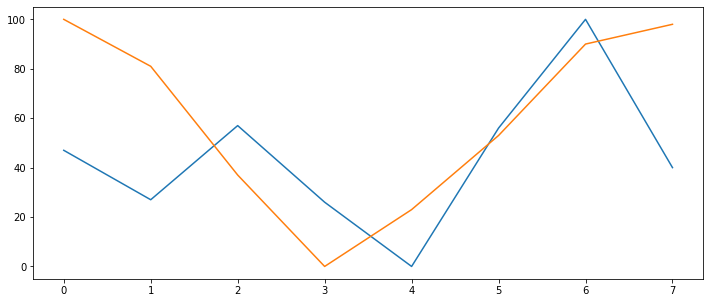

In [16]:
plt.figure(figsize=(12, 5))
sample = dataset_train[0][0]
for i in range(dims_num):
    plt.plot(sample[i])
plt.show()

In [50]:
features = LSTMFeatures(dims_num, magic_dim, 1, lstm_dropout=0.0)
net = LSTMClassifier(features, magic_dim, num_classes)
criterion = nn.CrossEntropyLoss()
losses = []
test_losses = []
test_iters = []
test_accuracies = []

In [51]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
# optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=5e-4)

In [52]:
loss, acc, _, _ = evaluate_net(net, criterion, dataloader_test)
print('test loss:', loss, 'test accuracy:', acc)

test loss: 2.3494891542376894 test accuracy: 0.0963407661520869


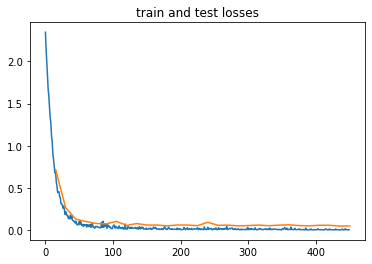

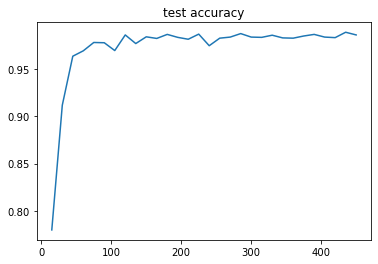

test loss: 0.04799596291395376 test accuracy: 0.9865637507146942


In [53]:
for epoch in range(30):
    print('epoch:', epoch)
    run_epoch(epoch, net, optimizer, criterion, dataloader_train, losses)
    loss, acc, _, _ = evaluate_net(net, criterion, dataloader_test)
    clear_output()
    plt.title('train and test losses')
    plt.plot(losses)
    test_losses.append(loss)
    test_accuracies.append(acc)
    test_iters.append(len(losses))
    plt.plot(test_iters, test_losses)
    plt.show()
    plt.title('test accuracy')
    plt.plot(test_iters, test_accuracies)
    plt.show()
    print('test loss:', loss, 'test accuracy:', acc)

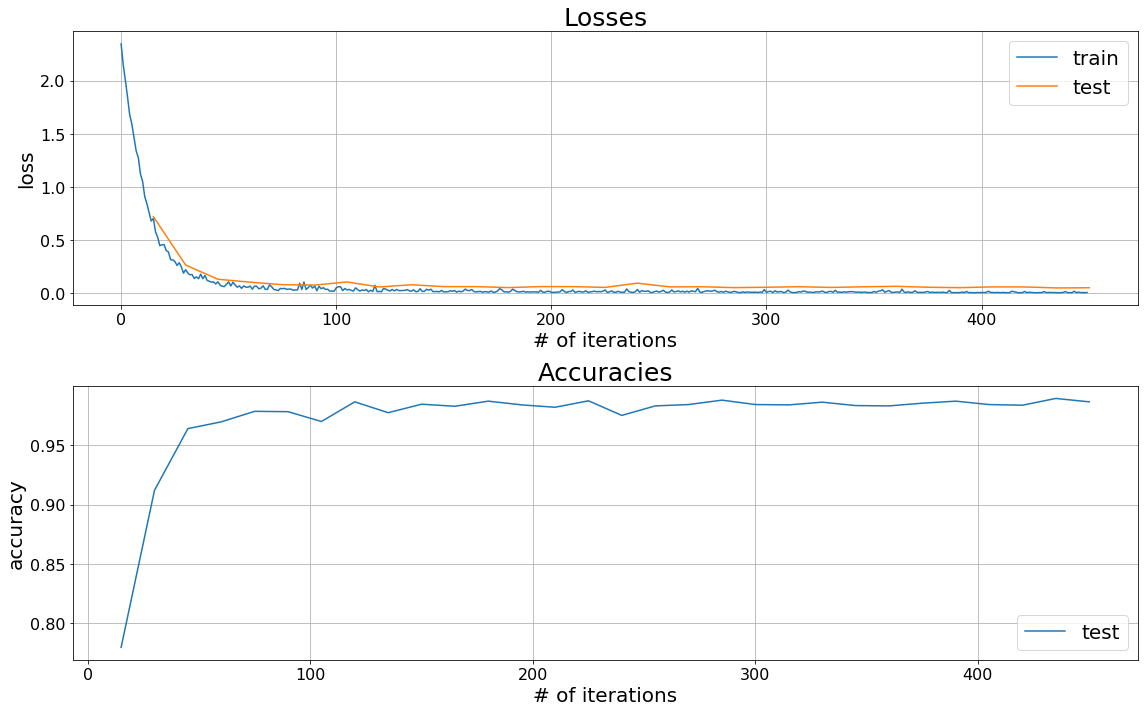

In [54]:
# beautiful plots
fig, ax = plt.subplots(figsize=(16, 10), nrows=2, ncols=1)
# losses
ax[0].set_title('Losses', fontsize=25)
ax[0].set_xlabel('# of iterations', fontsize=20)
ax[0].set_ylabel('loss', fontsize=20)
ax[0].grid()
ax[0].plot(losses, label='train')
ax[0].plot(test_iters, test_losses, label='test')
ax[0].legend(fontsize=20)
for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
# accuracy
ax[1].set_title('Accuracies', fontsize=25)
ax[1].set_xlabel('# of iterations', fontsize=20)
ax[1].set_ylabel('accuracy', fontsize=20)
ax[1].grid()
ax[1].plot(test_iters, test_accuracies, label='test')
ax[1].legend(fontsize=20)
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(16)

plt.tight_layout()
plt.savefig('pen_digits_plots.png', dpi=300, fmt='png')

## Sinkhorn-Knopp optimization

In [21]:
def optimize_L_sk(PS):
    N, K = PS.shape
    tt = time.time()
    PS = PS.T  # now it is K x N
    r = np.ones((K, 1)) / K
    c = np.ones((N, 1)) / N
    PS **= lamb  # K x N
    inv_K = 1. / K
    inv_N = 1. / N
    err = 1e3
    _counter = 0
    while err > 1e-2:
        r = inv_K / (PS @ c)  # (KxN)@(N,1) = K x 1
        c_new = inv_N / (r.T @ PS).T  # ((1,K)@(KxN)).t() = N x 1
        if _counter % 10 == 0:
            err = np.nansum(np.abs(c / c_new - 1))
        c = c_new
        _counter += 1
        
    print("error: ", err, 'step ', _counter, flush=True)  # " nonneg: ", sum(I), flush=True)
    # inplace calculations.
    PS *= np.squeeze(c)
    PS = PS.T
    PS *= np.squeeze(r)
    PS = PS.T
    argmaxes = np.nanargmax(PS, 0)  # size N
    newL = torch.LongTensor(argmaxes)
    selflabels = newL.to(device)
    PS = PS.T
    PS /= np.squeeze(r)
    PS = PS.T
    PS /= np.squeeze(c)
    sol = PS[argmaxes, np.arange(N)]
    np.log(sol, sol)
    cost = -(1. / lamb) * np.nansum(sol) / N
    print('cost: ', cost, flush=True)
    print('opt took {0:.2f}min, {1:4d}iters'.format(((time.time() - tt) / 60.), _counter), flush=True)
    return cost, selflabels

def opt_sk(model, selflabels_in, epoch):
    if hc == 1:
        PS = np.zeros((N, ncl))
    else:
        PS_pre = np.zeros((N, magic_dim)) # knn_dim
    
    for batch_idx, (data, _, _selected) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=True)):
        data = data.to(device)#cuda()
        if hc == 1:
            p = nn.functional.softmax(model(data), 1)
            PS[_selected, :] = p.detach().cpu().numpy()
        else:
            p = model(data.float())
            PS_pre[_selected, :] = p.detach().cpu().numpy()
    if hc == 1:
        cost, selflabels = optimize_L_sk(PS)
        _costs = [cost]
    else:
        _nmis = np.zeros(hc)
        _costs = np.zeros(hc)
        nh = epoch % hc  # np.random.randint(args.hc)
        print("computing head %s " % nh, end="\r", flush=True)
        tl = getattr(model, "top_layer%d" % nh)
        # do the forward pass:
        PS = (PS_pre @ tl.weight.cpu().numpy().T
                   + tl.bias.cpu().numpy())
        PS = py_softmax(PS, 1)
        c, selflabels_ = optimize_L_sk(PS)
        _costs[nh] = c
        selflabels_in[nh] = selflabels_
        selflabels = selflabels_in
    return selflabels

## Training utils

In [22]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = alr
    if epochs == 200:
        if epoch >= 80:
            lr = alr * (0.1 ** ((epoch - 80) // 40))  # i.e. 120, 160
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 400:
        if epoch >= 160:
            lr = alr * (0.1 ** ((epoch - 160) // 80))  # i.e. 240,320
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 800:
        if epoch >= 320:
            lr = alr * (0.1 ** ((epoch - 320) // 160))  # i.e. 480, 640
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 1600:
        if epoch >= 640:
            lr = alr * (0.1 ** ((epoch - 640) // 320))
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [23]:
def feature_return_switch(model, bool=True):
    """
    switch between network output or conv5features
        if True: changes switch s.t. forward pass returns post-conv5 features
        if False: changes switch s.t. forward will give full network output
    """
    if bool:
        model.headcount = 1
    else:
        model.headcount = hc
    model.return_feature = bool

In [24]:
def train(epoch, selflabels):
    print('\nEpoch: %d' % epoch)
    print(name)
    adjust_learning_rate(optimizer, epoch)
    train_loss = AverageMeter()
    data_time = AverageMeter()
    batch_time = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    
    for batch_idx, (inputs, targets, indexes) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=True)):
        inputs = inputs.float().to(device)
        niter = epoch * N/batch_size + batch_idx
        if niter * batch_size >= optimize_times[-1]:
            with torch.no_grad():
                _ = optimize_times.pop()
                if hc >1:
                    feature_return_switch(model, True)
                selflabels = opt_sk(model, selflabels, epoch)
                if hc >1:
                    feature_return_switch(model, False)
        data_time.update(time.time() - end)
        inputs, targets = inputs.to(device), targets.to(device)#, indexes.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        if hc == 1:
            loss = criterion(outputs, selflabels[indexes])
        else:
            loss = torch.mean(torch.stack([criterion(outputs[h],
                                                     selflabels[h, indexes]) for h in range(hc)]))

        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
#         if True:
        if batch_idx % 10 == 0:
            print('Epoch: [{}][{}/{}]'
                  'Time: {batch_time.val:.3f} ({batch_time.avg:.3f}) '
                  'Data: {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Loss: {train_loss.val:.4f} ({train_loss.avg:.4f})'.format(
                epoch, batch_idx, N/batch_size, batch_time=batch_time, data_time=data_time, train_loss=train_loss))
#             writer.add_scalar("loss", loss.item(), batch_idx*512 +epoch*N/batch_size)
    return selflabels

## Model initialization

In [25]:
features = LSTMFeatures(dims_num, magic_dim, 1, lstm_dropout=0.0)
model = LSTMMultiHeadClassifier(features, magic_dim, numc, dropout=0.0)

In [26]:
optimize_times = ((epochs + 1.0001)*N*(np.linspace(0, 1, nopts))[::-1]).tolist()
optimize_times = [(epochs +10)*N] + optimize_times
print('We will optimize L at epochs:', [np.round(1.0*t/N, 2) for t in optimize_times], flush=True)

We will optimize L at epochs: [110.0, 101.0, 98.94, 96.88, 94.82, 92.76, 90.69, 88.63, 86.57, 84.51, 82.45, 80.39, 78.33, 76.27, 74.2, 72.14, 70.08, 68.02, 65.96, 63.9, 61.84, 59.78, 57.71, 55.65, 53.59, 51.53, 49.47, 47.41, 45.35, 43.29, 41.22, 39.16, 37.1, 35.04, 32.98, 30.92, 28.86, 26.8, 24.73, 22.67, 20.61, 18.55, 16.49, 14.43, 12.37, 10.31, 8.24, 6.18, 4.12, 2.06, 0.0]


In [27]:
# init selflabels randomly
if hc == 1:
    selflabels = np.zeros(N, dtype=np.int32)
    for qq in range(N):
        selflabels[qq] = qq % ncl
    selflabels = np.random.permutation(selflabels)
    selflabels = torch.LongTensor(selflabels).to(device)
else:
    selflabels = np.zeros((hc, N), dtype=np.int32)
    for nh in range(hc):
        for _i in range(N):
            selflabels[nh, _i] = _i % numc[nh]
        selflabels[nh] = np.random.permutation(selflabels[nh])
    selflabels = torch.LongTensor(selflabels).to(device)

In [28]:
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=lr)
model.to(device)
criterion = nn.CrossEntropyLoss()

In [29]:
name = "LSTM-PenDigits"
writer = SummaryWriter(f'./runs/pendigits/{name}')

## Training! 
Takes a couple of minutes per epoch

In [30]:
def my_kNN(net, K, sigma=0.1, dim=128, use_pca=False):
    net.eval()
    # this part is ugly but made to be backwards-compatible. there was a change in cifar dataset's structure.
    trainLabels = y_train
    LEN = N
    C = trainLabels.max() + 1

    trainFeatures = torch.zeros((magic_dim, LEN))  # , device='cuda:0') # dim
    normalize = Normalize()
    normalize.to(device)
    for batch_idx, (inputs, targets, _) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=False)):
        batchSize = batch_size
        inputs = inputs.to(device)
        features = net(inputs.float())
        if not use_pca:
            features = normalize(features)
        tmp = trainFeatures[:, batch_idx * batchSize:batch_idx * batchSize + batchSize]
        trainFeatures[:, batch_idx * batchSize:batch_idx * batchSize + batchSize] = features.data.t().cpu()
        
    if use_pca:
        comps = dim
        print('doing PCA with %s components'%comps, end=' ')
        from sklearn.decomposition import PCA
        pca = PCA(n_components=comps, whiten=False)
        trainFeatures = pca.fit_transform(trainFeatures.numpy().T)
        trainFeatures = torch.Tensor(trainFeatures).to(device)
        trainFeatures = normalize(trainFeatures).t().cpu()
        print('..done')
    def eval_k_s(K_,sigma_):
        total = 0
        top1 = 0.
#         top5 = 0.

        with torch.no_grad():
            retrieval_one_hot = torch.zeros(K_, C)# .cuda()
            for batch_idx, (inputs, targets, _) in enumerate(iterate_minibatches(X_test, y_test, batch_size, shuffle=False)):
                targets = targets # .cuda(async=True) # or without async for py3.7
                inputs = inputs.to(device)
                batchSize = batch_size
                features = net(inputs.float())
                if use_pca:
                    features = pca.transform(features.cpu().numpy())
                    features = torch.Tensor(features).to(device)
                features = normalize(features).cpu()

                dist = torch.mm(features, trainFeatures)

                yd, yi = dist.topk(K_, dim=1, largest=True, sorted=True)
                candidates = trainLabels.view(1, -1).expand(batchSize, -1)
                retrieval = torch.gather(candidates, 1, yi).long()

                retrieval_one_hot.resize_(batchSize * K_, C).zero_()
                retrieval_one_hot.scatter_(1, retrieval.view(-1, 1), 1.)
                
                yd_transform = yd.clone().div_(sigma_).exp_()
                probs = torch.sum(torch.mul(retrieval_one_hot.view(batchSize, -1, C),
                                            yd_transform.view(batchSize, -1, 1)),
                                  1)
                _, predictions = probs.sort(1, True)

                # Find which predictions match the target
                correct = predictions.eq(targets.data.view(-1, 1))

                top1 = top1 + correct.narrow(1, 0, 1).sum().item()
#                 top5 = top5 + correct.narrow(1, 0, 5).sum().item()

                total += targets.size(0)

        print(f"{K_}-NN,s={sigma_}: TOP1: ", top1 * 100. / total)
        return top1 / total

    if isinstance(K, list):
        res = []
        for K_ in K:
            for sigma_ in sigma:
                res.append(eval_k_s(K_, sigma_))
        return res
    else:
        res = eval_k_s(K, sigma)
        return res

In [31]:
import time

start = time.time()
for epoch in range(start_epoch, start_epoch + epochs):
    selflabels = train(epoch, selflabels)
    feature_return_switch(model, True)
    
    acc = my_kNN(model, K=10, sigma=0.1, dim=knn_dim)
    feature_return_switch(model, False)
#     writer.add_scalar("accuracy kNN", acc, epoch)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'opt': optimizer.state_dict(),
            'L': selflabels,
        }
        if not os.path.isdir(exp):
            os.mkdir(exp)
        torch.save(state, '%s/best_ckpt.t7' % (exp))
        best_acc = acc
    if epoch % 100 == 0:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'opt': optimizer.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'L': selflabels,
        }
        if not os.path.isdir(exp):
            os.mkdir(exp)
        torch.save(state, '%s/ep%s.t7' % (exp, epoch))
    if epoch % 50 == 0:
        feature_return_switch(model, True)
        acc = my_kNN(model, K=[50, 10], sigma=[0.1, 0.5], dim=knn_dim, use_pca=True)
        i = 0
#         for num_nn in [50, 10]:
#             for sig in [0.1, 0.5]:
#                 writer.add_scalar('knn%s-%s' % (num_nn, sig), acc[i], epoch)
#                 i += 1
        feature_return_switch(model, False)
    print('best accuracy: {:.2f}'.format(best_acc * 100))
end = time.time()

checkpoint = torch.load('%s'%exp+'/best_ckpt.t7' )
model.load_state_dict(checkpoint['net'])
feature_return_switch(model, True)
acc = my_kNN(model, K=10, sigma=0.1, dim=knn_dim, use_pca=True)


Epoch: 0
LSTM-PenDigits
error:  8.104642890471858e-06 step  21
cost:  2.162629692057636
opt took 0.00min,   21iters
Epoch: [0][0/14.988]Time: 0.170 (0.170) Data: 0.132 (0.132) Loss: 2.3117 (2.3117)
Epoch: [0][10/14.988]Time: 0.032 (0.046) Data: 0.001 (0.013) Loss: 2.2801 (2.2914)
10-NN,s=0.1: TOP1:  88.2
Saving..
Saving..
doing PCA with 128 components ..done
50-NN,s=0.1: TOP1:  82.06666666666666
50-NN,s=0.5: TOP1:  81.43333333333334
10-NN,s=0.1: TOP1:  88.7
10-NN,s=0.5: TOP1:  88.26666666666667
best accuracy: 88.20

Epoch: 1
LSTM-PenDigits
Epoch: [1][0/14.988]Time: 0.051 (0.051) Data: 0.002 (0.002) Loss: 2.2647 (2.2647)
Epoch: [1][10/14.988]Time: 0.033 (0.037) Data: 0.001 (0.001) Loss: 2.2647 (2.2660)
10-NN,s=0.1: TOP1:  88.3
Saving..
best accuracy: 88.30

Epoch: 2
LSTM-PenDigits
Epoch: [2][0/14.988]Time: 0.028 (0.028) Data: 0.001 (0.001) Loss: 2.2541 (2.2541)
error:  0.005943842873321392 step  11
cost:  2.157372932607252
opt took 0.00min,   11iters
Epoch: [2][10/14.988]Time: 0.035 (0

opt took 0.00min,   31iters
10-NN,s=0.1: TOP1:  95.0
best accuracy: 95.33

Epoch: 27
LSTM-PenDigits
Epoch: [27][0/14.988]Time: 0.031 (0.031) Data: 0.001 (0.001) Loss: 1.4149 (1.4149)
Epoch: [27][10/14.988]Time: 0.034 (0.034) Data: 0.001 (0.001) Loss: 1.4211 (1.4135)
10-NN,s=0.1: TOP1:  95.3
best accuracy: 95.33

Epoch: 28
LSTM-PenDigits
Epoch: [28][0/14.988]Time: 0.029 (0.029) Data: 0.002 (0.002) Loss: 1.3774 (1.3774)
Epoch: [28][10/14.988]Time: 0.028 (0.028) Data: 0.001 (0.001) Loss: 1.3901 (1.3823)
error:  0.000454974957945109 step  41
cost:  1.6035872880267872
opt took 0.00min,   41iters
10-NN,s=0.1: TOP1:  95.4
Saving..
best accuracy: 95.40

Epoch: 29
LSTM-PenDigits
Epoch: [29][0/14.988]Time: 0.035 (0.035) Data: 0.001 (0.001) Loss: 1.3468 (1.3468)
Epoch: [29][10/14.988]Time: 0.032 (0.034) Data: 0.001 (0.001) Loss: 1.3486 (1.3417)
10-NN,s=0.1: TOP1:  95.33333333333333
best accuracy: 95.40

Epoch: 30
LSTM-PenDigits
Epoch: [30][0/14.988]Time: 0.029 (0.029) Data: 0.001 (0.001) Loss: 1.

Epoch: [54][10/14.988]Time: 0.032 (0.033) Data: 0.001 (0.001) Loss: 0.5901 (0.5892)
10-NN,s=0.1: TOP1:  95.76666666666667
best accuracy: 95.80

Epoch: 55
LSTM-PenDigits
Epoch: [55][0/14.988]Time: 0.029 (0.029) Data: 0.001 (0.001) Loss: 0.5506 (0.5506)
error:  0.005413477805118805 step  61
cost:  1.0987107804627743
opt took 0.00min,   61iters
Epoch: [55][10/14.988]Time: 0.173 (0.045) Data: 0.135 (0.013) Loss: 0.5709 (0.5598)
10-NN,s=0.1: TOP1:  95.73333333333333
best accuracy: 95.80

Epoch: 56
LSTM-PenDigits
Epoch: [56][0/14.988]Time: 0.032 (0.032) Data: 0.001 (0.001) Loss: 0.5304 (0.5304)
Epoch: [56][10/14.988]Time: 0.031 (0.032) Data: 0.001 (0.001) Loss: 0.5417 (0.5340)
10-NN,s=0.1: TOP1:  95.66666666666667
best accuracy: 95.80

Epoch: 57
LSTM-PenDigits
Epoch: [57][0/14.988]Time: 0.030 (0.030) Data: 0.001 (0.001) Loss: 0.5091 (0.5091)
Epoch: [57][10/14.988]Time: 0.029 (0.030) Data: 0.001 (0.001) Loss: 0.5248 (0.5144)
error:  0.00287974182822881 step  71
cost:  1.0471634768291418
opt t

error:  0.009728652770219837 step  731
cost:  0.28545758342355476
opt took 0.00min,  731iters
Epoch: [82][10/14.988]Time: 0.033 (0.057) Data: 0.001 (0.022) Loss: 0.2596 (0.2408)
10-NN,s=0.1: TOP1:  95.66666666666667
best accuracy: 95.93

Epoch: 83
LSTM-PenDigits
Epoch: [83][0/14.988]Time: 0.031 (0.031) Data: 0.002 (0.002) Loss: 0.2352 (0.2352)
Epoch: [83][10/14.988]Time: 0.030 (0.031) Data: 0.001 (0.001) Loss: 0.2459 (0.2355)
10-NN,s=0.1: TOP1:  95.83333333333333
best accuracy: 95.93

Epoch: 84
LSTM-PenDigits
Epoch: [84][0/14.988]Time: 0.032 (0.032) Data: 0.001 (0.001) Loss: 0.2231 (0.2231)
error:  0.009707086681980615 step  431
cost:  0.30020199671990677
opt took 0.00min,  431iters
Epoch: [84][10/14.988]Time: 0.036 (0.052) Data: 0.001 (0.019) Loss: 0.2437 (0.2268)
10-NN,s=0.1: TOP1:  95.9
best accuracy: 95.93

Epoch: 85
LSTM-PenDigits
Epoch: [85][0/14.988]Time: 0.029 (0.029) Data: 0.001 (0.001) Loss: 0.2277 (0.2277)
Epoch: [85][10/14.988]Time: 0.032 (0.032) Data: 0.001 (0.001) Loss: 0

In [32]:
acc = my_kNN(model, K=10, sigma=0.1, dim=64, use_pca=True)

doing PCA with 64 components ..done
10-NN,s=0.1: TOP1:  94.4
